Want to load a small tumbnail image into postgres db as a bytearray

https://www.quora.com/Can-we-store-images-jpg-in-databases-using-Python-If-yes-how

In [1]:
import io
from PIL import Image
import base64
import sys
import pandas as pd

from IPython.display import HTML

def pil_image_to_b64_str(image):
    """
    Convert PIL image to b64 string
    """
    imgByteArr = io.BytesIO()
    image.save(imgByteArr, format="JPEG")
    return base64.b64encode(imgByteArr.getvalue())

def pil_image_to_byte_array(image):
    imgByteArr = io.BytesIO()
    image.save(imgByteArr, "JPEG")
    return imgByteArr.getvalue()

def byte_array_to_pil_image(byte_array):
    return Image.open(io.BytesIO(byte_array))

In [2]:
filepath = "cat.jpg"
img = Image.open(filepath)

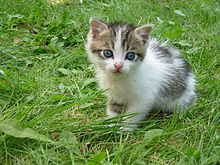

In [3]:
img

In [4]:
img_byte_array = pil_image_to_byte_array(img)

In [5]:
sys.getsizeof(img_byte_array)

14427

In [6]:
img_byte_array[:30]

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06'

In [7]:
type(img_byte_array)

bytes

Recover image

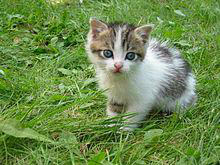

In [8]:
byte_array_to_pil_image(img_byte_array)

## Store in base64 string

We can transmit the data as string via a message, or store in db as str ot bytea datatype

In [9]:
def bytes_to_b64_str(byte_array):
    return base64.b64encode(byte_array).decode()

In [10]:
b64_str = bytes_to_b64_str(img_byte_array)

In [11]:
sys.getsizeof(b64_str)

19241

In [12]:
type(b64_str)

str

In [13]:
b64_str[:10]

'/9j/4AAQSk'

## Store bytearray in Postgres

https://www.quora.com/Can-we-store-images-jpg-in-databases-using-Python-If-yes-how

```sql
CREATE TABLE IMAGE_TABLE ( image_id   INT GENERATED ALWAYS AS IDENTITY,
                           image_name VARCHAR2(50),
                           image_content BYTEA
                           );
```

In [14]:
from sqlalchemy import create_engine, inspect
from sqlalchemy import MetaData, Column, Table, ForeignKey
from sqlalchemy import Integer, String, LargeBinary
from sqlalchemy.sql import select

In [15]:
engine = create_engine('postgresql://localhost/robincole') 

Create a table for our image using sqlalchemy

In [16]:
metadata = MetaData(bind=engine)

image_table = Table('images', metadata,
                    Column('id', Integer, primary_key=True),
                    Column('image_name', String(50)),
                    Column('image_content', LargeBinary),
                    )

In [17]:
# create tables in database
metadata.create_all()

In [18]:
inspector = inspect(engine)

In [19]:
inspector.get_table_names()

['images']

In [20]:
inspector.get_columns('images')

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': "nextval('images_id_seq'::regclass)",
  'autoincrement': True,
  'comment': None},
 {'name': 'image_name',
  'type': VARCHAR(length=50),
  'nullable': True,
  'default': None,
  'autoincrement': False,
  'comment': None},
 {'name': 'image_content',
  'type': BYTEA(),
  'nullable': True,
  'default': None,
  'autoincrement': False,
  'comment': None}]

Insert the image

In [21]:
# create an Insert object
ins = image_table.insert()
# add values to the Insert object
new_image = ins.values(image_name="cat.jpg", image_content=img_byte_array)
 
# create a database connection
conn = engine.connect()
# add user to database by executing SQL
conn.execute(new_image)

We can then view the data using postico

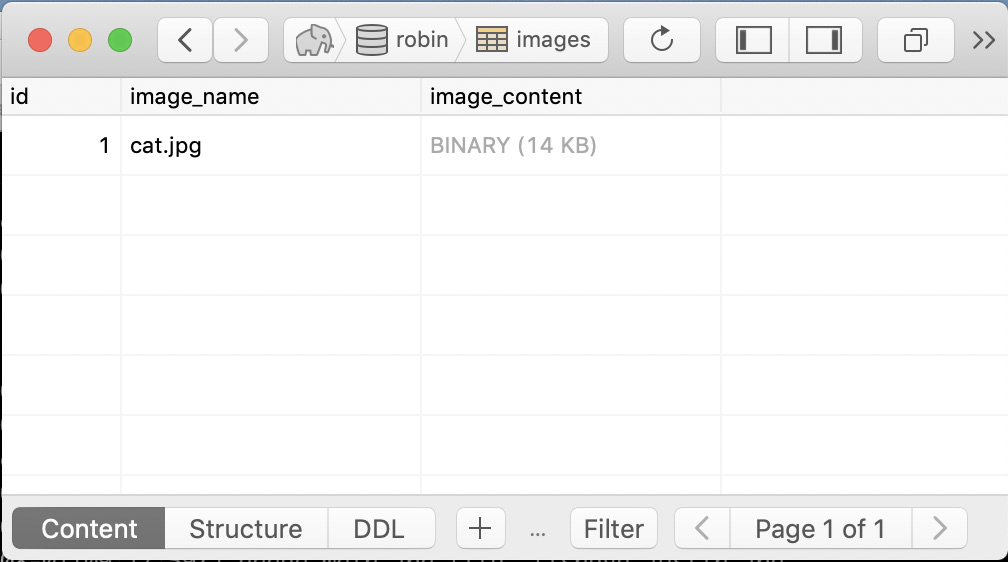

In [22]:
Image.open("postico_cat.jpg")

In [23]:
s = select([image_table])
result = s.execute()
 
for row in result:
    print(row)

(1, 'cat.jpg', b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0 ... (40977 characters truncated) ... \xb4\xd5n%{\xb9#\xdb\x0c6\xc0\xaf\x96\xa3\x97<\x8c\x96?N\x98\xac;_\x17j\x16\x82T\x048i\x0b\x0c\x93\xf2\xf08\x1f\x95\x14V\xd4c\x17}\n\x8a\xba?\xff\xd9')


The image may appear more than once as I have run this notebook a couple of times. 

Access the image data

In [24]:
s = select([image_table], image_table.c.id == 1)
result = conn.execute(s)
data = result.fetchone()

In [25]:
data

(1, 'cat.jpg', b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0 ... (40977 characters truncated) ... \xb4\xd5n%{\xb9#\xdb\x0c6\xc0\xaf\x96\xa3\x97<\x8c\x96?N\x98\xac;_\x17j\x16\x82T\x048i\x0b\x0c\x93\xf2\xf08\x1f\x95\x14V\xd4c\x17}\n\x8a\xba?\xff\xd9')

In [26]:
img_content = data[2]

In [27]:
img_content[:10]

b'\xff\xd8\xff\xe0\x00\x10JFIF'

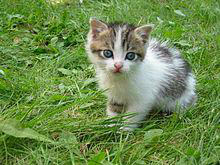

In [28]:
byte_array_to_pil_image(img_content)

## Read data back with pandas

In [29]:
sql = "select * from images"
print('Performing query...')
df = pd.read_sql(sql, con=engine)

Performing query...


In [30]:
df

,id,image_name,image_content
0,1,cat.jpg,"[b'\xff', b'\xd8', b'\xff', b'\xe0', b'\x00', ..."


In [31]:
df['image'] = df['image_content'].map(lambda f: byte_array_to_pil_image(f))

In [32]:
df.head()

,id,image_name,image_content,image
0,1,cat.jpg,"[b'\xff', b'\xd8', b'\xff', b'\xe0', b'\x00', ...",<PIL.JpegImagePlugin.JpegImageFile image mode=...


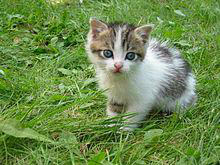

In [33]:
df.iloc[0]["image"]